In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from scipy.optimize import Bounds, BFGS
from scipy.optimize import LinearConstraint, minimize
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import sklearn.datasets as dt
from math import log, e, sqrt,comb


In [3]:
train_df = pd.read_csv("/kaggle/input/svm-classification/UniversalBank.csv")
train_df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


# Generate linearly separable dataset

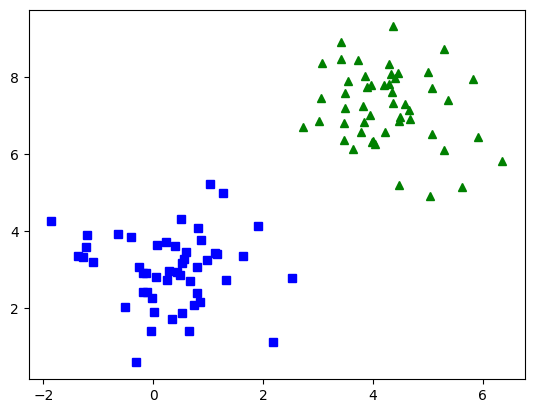

In [4]:
import matplotlib.pyplot as plt
from sklearn import datasets

X, y = datasets.make_blobs(n_samples=100, centers=2, n_features=2, center_box=(0, 10),random_state=1)
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'g^')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
plt.show()

In [6]:
# converting 0 classes to -1
print(y)
y[y == 0] = -1
print(y)

[0 1 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 1 0 1 1 0
 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 1 1 1 0
 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0]
[-1  1 -1 -1  1  1  1  1 -1 -1  1 -1  1 -1  1  1  1 -1 -1  1  1  1  1 -1
 -1  1  1 -1 -1  1 -1 -1  1 -1  1  1 -1  1  1  1  1  1 -1  1 -1  1 -1 -1
 -1 -1 -1  1  1  1 -1  1 -1  1 -1 -1 -1  1  1  1  1  1 -1  1 -1 -1  1  1
  1 -1 -1 -1  1  1 -1 -1 -1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1
  1 -1  1 -1]


In [8]:
from sklearn.model_selection import train_test_split
X_train ,X_test ,y_train ,y_test=train_test_split(X , y, test_size=0.25,random_state=0)
print(X_train.shape,y_train.shape)
print(X_test.shape)
print("")

(75, 2) (75,)
(25, 2)



In [9]:
def lagrange_dual(alpha, x, y,dim):
    # result to hold final result of lagrange_dual
    result_v=np.zeros(x.shape[0]).reshape(1,-1)
    # indexes of support vectors
    ind_sv = np.where(alpha > epsilon)[0]
    for i in ind_sv:
        result_v+= alpha[i]*alpha*y[i]*y*((np.dot((x[i]).reshape(-1,1).T,x.T))**dim)
    result_v = 0.5*result_v - alpha
    return np.sum(result_v.reshape(-1,1),axis=0)[0]

In [10]:
def optimize_alpha(x, y, C,dim):
    m, n = x.shape
    np.random.seed(1)
    # Initialize alphas to random values
    alpha_0 = np.random.rand(m)*C
    # Define the constraint
    linear_constraint = LinearConstraint(y, [0], [0])
    # Define the bounds
    bounds_alpha = Bounds(np.zeros(m), np.full(m, C))
    # Find the optimal value of alpha
    result = minimize(lagrange_dual, alpha_0, args = (x, y,dim), method='trust-constr',
                      hess=BFGS(), constraints=[linear_constraint],
                      bounds=bounds_alpha)
    # The optimized value of alpha lies in result.x
    alpha = result.x
    return alpha

In [11]:
def calculate_w(alpha, y, x):
    w=alpha.reshape(-1,1)*y.reshape(-1,1)*x
    return np.sum(w,axis=0)

def calculate_b(alpha, y, x, w, C,dim):
    C_numeric = C-epsilon
    # Indices of support vectors with alpha<C
    ind_sv = np.where((alpha > epsilon)&(alpha < C_numeric))[0]
    # Take the average
    b=y[np.where((alpha > epsilon)&(alpha < C_numeric))[0]]-(np.dot(x[np.where((alpha > epsilon)&(alpha < C_numeric))[0]],w))**dim
    b = b / len(ind_sv)
    return np.sum(b)

In [12]:
def classify_points(x, w, b,dim):
    # get y(x)
    predicted_labels = np.sum((x*w)**dim, axis=1) + b
    # sign method is used for: if array value is greater than 0 it returns 1, if array value is less than 0 it returns -1, and if array value 0 it returns 0.
    predicted_labels = np.sign(predicted_labels)
    # Assign a label arbitrarily a -1 if it is zero
    predicted_labels[predicted_labels==0] = -1
    return predicted_labels

def misclassification_rate(labels, predictions):
    total = len(labels)
    errors = sum(labels != predictions)
    return errors/total

In [14]:
def Gen_Error(empirical_err,x,VC,delta):
    Gen_err=[]
    Gen_err.append(empirical_err + sqrt((8/x.shape[0]) * log(((4 * (2 * x.shape[0])**VC)+1)/delta)))
    Gen_err.append(empirical_err + sqrt((2 * VC * log((e * x.shape[0]) / VC)) / x.shape[0]) + sqrt(log(1 / delta) /2 * x.shape[0]))
  # choose maximum Generalization error
    return max(Gen_err)

def plot_hyperplane(w, b):
    x_coord = np.array(plt.gca().get_xlim())
    y_coord = -b/w[1] - w[0]/w[1] * x_coord
    plt.plot(x_coord, y_coord, color='red')

def plot_margin(w, b):
    x_coord = np.array(plt.gca().get_xlim())
    ypos_coord = 1/w[1] - b/w[1] - w[0]/w[1] * x_coord
    plt.plot(x_coord, ypos_coord, '--', color='green')
    yneg_coord = -1/w[1] - b/w[1] - w[0]/w[1] * x_coord
    plt.plot(x_coord, yneg_coord, '--', color='magenta')
def plot_x(x, y, alpha=[], C=0):
    sns.scatterplot(x=x[:,0],y=x[:, 1], style=y,
    hue=y, markers=['s', 'P'],
    palette=['magenta', 'green'])
    if len(alpha) > 0:
        alpha_str = np.char.mod('%.1f', np.round(alpha, 1))
        ind_sv = np.where(alpha > epsilon)[0]
        for i in ind_sv:
            plt.gca().text(x[i,0], x[i, 1]-.25, alpha_str[i] )

In [15]:
def display_SVM_result(x, y, C,dim,kernel):
    # Get the alphas
    alpha = optimize_alpha(x, y, C,dim)
    # Get the weights
    w = calculate_w(alpha, y, x)
    b = calculate_b(alpha, y, x, w, C,dim)
    if not kernel:
        plot_x(x, y, alpha, C)
        xlim = plt.gca().get_xlim()
        ylim = plt.gca().get_ylim()
        plot_hyperplane(w, b)
        plot_margin(w, b)
        plt.xlim(xlim)
        plt.ylim(ylim)
    # measuring VC dimension, combination(n+k,n)
    if kernel:
        VC=comb(w.shape[0]+dim,w.shape[0])
    # measuring VC dimension, VC=d+1
    else:
        VC=w.shape[0]+1
    # measuring delta
    delta = 0.5
    # Training
    predictions = classify_points(x, w, b,dim)
    empirical_err = misclassification_rate(y, predictions)
    Gen_Error_Calc=Gen_Error(empirical_err,x,VC,delta)
    title = 'C = ' + str(C) + ',  Gen_Error: ' + '{:.1f}'.format(Gen_Error_Calc) + '%' + ',  VC= ' + str(VC)
    title = title + ',  total SV = ' + str(len(alpha[alpha > epsilon]))
    if not kernel:
        plt.title(title)
    return w,b,dim,title

In [19]:
epsilon = 1e-3

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_differentiable_functions.py:317: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


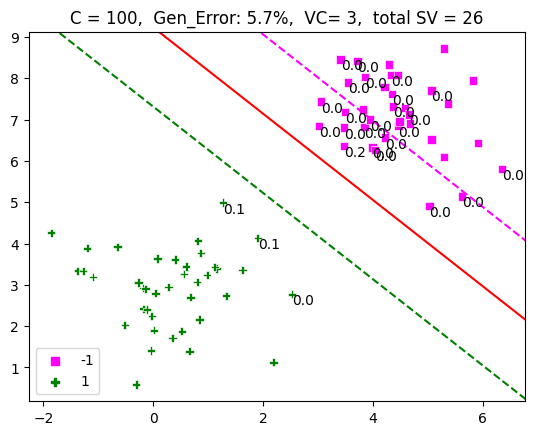

In [20]:
w,b,dim,_=display_SVM_result(X_train, y_train, 100,1,False)
plt.show()